Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')
           CRIM          ZN      INDUS      CHAS       NOX        RM  \
mean   3.611874   11.211934  11.083992  0.069959  0.554695  6.284634   
std    8.720192   23.388876   6.835896  0.255340  0.115878  0.702617   
min    0.006320    0.000000   0.460000  0.000000  0.385000  3.561000   
max   88.976200  100.000000  27.740000  1.000000  0.871000  8.780000   

             AGE        DIS        RAD         TAX    PTRATIO           B  \
mean   68.518519   3.795043   9.549407  408.237154  18.455534  356.674032   
std    27.999513   2.105710   8.707259  168.537116   2.164946   91.294864   
min     2.900000   1.129600   1.000000  187.000000  12.600000    0.320000   
max   100.000000  12.126500  24.000000  711.000000  22.000000  396.900000   

          LSTAT       MEDV  
mean  12.715432  22.532806  
std    7.155871   9.197104  
min    1.730000   5.0000

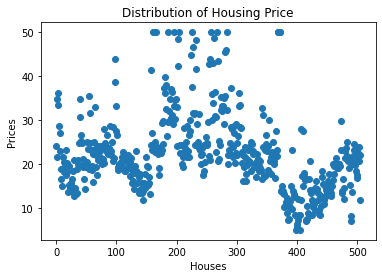

In [1]:
"""
DATA LOADING AND PREPROCESSING
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading Boston Housing Dataset
df = pd.read_csv('./HousingData.csv')
print(df.columns)

# Use describe() to generate statistics in pandas dataframe
description = df.describe()

# Print the statistics
print(description.loc[['mean', 'std', 'min', 'max']]) # loc for label based retrieval of rows

# Create a scatter plot
y = np.array(df["MEDV"])
plt.scatter(range(len(y)), y)
plt.xlabel('Houses')
plt.ylabel('Prices')
plt.title('Distribution of Housing Price')
plt.show()

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, log_loss

# Step 1: Handle Missing Values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df)

y = X[:, -1] # MEDV column is taken
y_min = np.min(y)
y_max = np.max(y)
y = (y - y_min) / (y_max-y_min)
y = y.reshape(-1, 1)    # column vector, as samples are represented by a row

X = X[:, :-1]

# Step 3: Normalize Data (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
X = scaler_minmax.fit_transform(X)

# Step 4: Split the data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Further split the train set into train and validation sets (e.g., 64% train, 16% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(X_train.shape)
print(y_train.shape)

(323, 13)
(323, 1)


In [4]:
import numpy as np
import wandb

# taken help from Chat GPT

class MLPRegressor:
    def __init__(self, learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[10], epochs=100):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.activation_functions = {
            'sigmoid': (self._sigmoid, self._sigmoid_derivative),
            'tanh': (np.tanh, self._tanh_derivative),
            'relu': (self._relu, self._relu_derivative)
        }
        self.weights = []
        self.biases = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        return z * (1 - z)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z

    def _tanh_derivative(self, z):
        return 1.0 - z**2

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward_propagation(self, X):
        activations = [X]
        Zs = []

        activation_func, _ = self.activation_functions[self.activation]

        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Zs.append(Z)
            if i == len(self.weights) - 1:  # If it's the last layer, use identity activation for regression
                activations.append(Z)
            else:
                activations.append(activation_func(Z))

        return activations, Zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return np.sum((y_pred - y_true)**2) / m

    def back_propagation(self, y, activations, Zs):
        m = y.shape[0]
        grads = {"dw": [], "db": []}

        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        grads["dw"].append(dW)
        grads["db"].append(db)

        _, activation_derivative = self.activation_functions[self.activation]

        for i in range(len(self.hidden_layers), 0, -1):
            dZ = np.dot(dZ, self.weights[i].T) * activation_derivative(activations[i])
            dW = np.dot(activations[i-1].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads["dw"].insert(0, dW)
            grads["db"].insert(0, db)

        return grads

    def update_weights(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dw"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def compute_r_squared(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true))**2)
        ss_res = np.sum((y_true - y_pred)**2)
        return 1 - (ss_res / ss_total)

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Initialize wandb
        
        self._initialize_weights(X_train.shape[1], y_train.shape[1])

        for epoch in range(self.epochs):
            # ... [rest of the training code] ...

            train_activations, _ = self.forward_propagation(X_train)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            train_rmse = np.sqrt(train_loss)
            train_r2 = self.compute_r_squared(y_train, train_activations[-1])

            metrics = {'Train MSE': train_loss, 'Train RMSE': train_rmse, 'Train R2': train_r2}

            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_activations[-1])
                val_rmse = np.sqrt(val_loss)
                val_r2 = self.compute_r_squared(y_val, val_activations[-1])

                metrics['Validation MSE'] = val_loss
                metrics['Validation RMSE'] = val_rmse
                metrics['Validation R2'] = val_r2

                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

            # Log metrics to wandb
            wandb.log(metrics)
    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return activations[-1]

### Sample run on a particular set of HP

In [5]:
config = {"lr" : 0.1, "activation" : "sigmoid" , "optimizer" : "sgd", "epochs" : 1000}
wandb.init(project="part3-ass3-smai",name="run1",config=config)

mlp = MLPRegressor(learning_rate=0.1, activation='sigmoid', optimizer='sgd', hidden_layers=[8, 4], epochs=1000)

# Train the model
mlp.fit(X_train,y_train,X_val,y_val)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rohan-victorious108. Use `wandb login --relogin` to force relogin


Epoch 1/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 2/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 3/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 4/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 5/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 6/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 7/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 8/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 9/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 10/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 11/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 12/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 13/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 14/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 15/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 16/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 17/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 18/1000 - train_loss: 0.2099 - val_loss: 0.2011
Epoch 19/1000 - train_loss: 0.2099 - 

In [ ]:
wandb.finish()

### Logging the different metrics in wandb `MSE`,`R-squared`,`RMSE`

In [4]:
import numpy as np
import wandb

class MLPRegressor:
    def __init__(self, learning_rate=0.01, activation='sigmoid', optimizer='sgd', hidden_layers=[10], epochs=100):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.activation_functions = {
            'sigmoid': (self._sigmoid, self._sigmoid_derivative),
            'tanh': (np.tanh, self._tanh_derivative),
            'relu': (self._relu, self._relu_derivative)
        }
        self.weights = []
        self.biases = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        return z * (1 - z)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z

    def _tanh_derivative(self, z):
        return 1.0 - z**2

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward_propagation(self, X):
        activations = [X]
        Zs = []

        activation_func, _ = self.activation_functions[self.activation]

        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Zs.append(Z)
            if i == len(self.weights) - 1:  # If it's the last layer, use identity activation for regression
                activations.append(Z)
            else:
                activations.append(activation_func(Z))

        return activations, Zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return np.sum((y_pred - y_true)**2) / m

    def compute_r_squared(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true))**2)
        ss_res = np.sum((y_true - y_pred)**2)
        return 1 - (ss_res / ss_total)

    def back_propagation(self, y, activations, Zs):
        m = y.shape[0]
        grads = {"dw": [], "db": []}

        dZ = activations[-1] - y
        dW = np.dot(activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        grads["dw"].append(dW)
        grads["db"].append(db)

        _, activation_derivative = self.activation_functions[self.activation]

        for i in range(len(self.hidden_layers), 0, -1):
            dZ = np.dot(dZ, self.weights[i].T) * activation_derivative(activations[i])
            dW = np.dot(activations[i-1].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads["dw"].insert(0, dW)
            grads["db"].insert(0, db)

        return grads

    def update_weights(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dw"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Initialize wandb
        
        self._initialize_weights(X_train.shape[1], y_train.shape[1])

        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                for i in range(X_train.shape[0]):
                    activations, Zs = self.forward_propagation(X_train[i:i+1])
                    grads = self.back_propagation(y_train[i:i+1], activations, Zs)
                    self.update_weights(grads)
            elif self.optimizer == 'bgd':
                activations, Zs = self.forward_propagation(X_train)
                grads = self.back_propagation(y_train, activations, Zs)
                self.update_weights(grads)
            elif self.optimizer == 'mbgd':
                batch_size = 32
                for i in range(0, X_train.shape[0], batch_size):
                    activations, Zs = self.forward_propagation(X_train[i:i+batch_size])
                    grads = self.back_propagation(y_train[i:i+batch_size], activations, Zs)
                    self.update_weights(grads)

            train_activations, _ = self.forward_propagation(X_train)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            train_rmse = np.sqrt(train_loss)
            train_r2 = self.compute_r_squared(y_train, train_activations[-1])

            metrics = {'Train MSE': train_loss, 'Train RMSE': train_rmse, 'Train R2': train_r2}

            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(y_val, val_activations[-1])
                val_rmse = np.sqrt(val_loss)
                val_r2 = self.compute_r_squared(y_val, val_activations[-1])

                metrics['Validation MSE'] = val_loss
                metrics['Validation RMSE'] = val_rmse
                metrics['Validation R2'] = val_r2

                print(f"Epoch {epoch+1}/{self.epochs} - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

            # Log metrics to wandb
            wandb.log(metrics)

    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return activations[-1]

In [5]:
config = {"lr" : 0.1, "activation" : "sigmoid" , "optimizer" : "sgd", "epochs" : 1000}
wandb.init(project="part3-ass3-smai",name="run2",config=config)

mlp = MLPRegressor(learning_rate=0.1, activation='sigmoid', optimizer='sgd', hidden_layers=[8, 4], epochs=1000)

# Train the model
mlp.fit(X_train,y_train,X_val,y_val)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rohan-victorious108. Use `wandb login --relogin` to force relogin


Epoch 1/1000 - train_loss: 0.0455 - val_loss: 0.0357
Epoch 2/1000 - train_loss: 0.0454 - val_loss: 0.0356
Epoch 3/1000 - train_loss: 0.0454 - val_loss: 0.0356
Epoch 4/1000 - train_loss: 0.0453 - val_loss: 0.0355
Epoch 5/1000 - train_loss: 0.0453 - val_loss: 0.0355
Epoch 6/1000 - train_loss: 0.0453 - val_loss: 0.0355
Epoch 7/1000 - train_loss: 0.0452 - val_loss: 0.0354
Epoch 8/1000 - train_loss: 0.0452 - val_loss: 0.0354
Epoch 9/1000 - train_loss: 0.0451 - val_loss: 0.0354
Epoch 10/1000 - train_loss: 0.0451 - val_loss: 0.0353
Epoch 11/1000 - train_loss: 0.0451 - val_loss: 0.0353
Epoch 12/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 13/1000 - train_loss: 0.0450 - val_loss: 0.0352
Epoch 14/1000 - train_loss: 0.0450 - val_loss: 0.0352
Epoch 15/1000 - train_loss: 0.0450 - val_loss: 0.0352
Epoch 16/1000 - train_loss: 0.0449 - val_loss: 0.0352
Epoch 17/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 18/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 19/1000 - train_loss: 0.0448 - 

### Combinations of Activation functions and optimizers

In [5]:
import wandb
def run_mlp_with_combinations(X_train, y_train, X_val=None, y_val=None, hidden_layers=[8,4], epochs=1000):
    # Activation functions and optimizers to iterate over
    activation_functions = ['sigmoid', 'tanh', 'relu']
    optimizers = ['sgd', 'bgd', 'mbgd']

    # Initialize wandb
    wandb.init(project="part3-ass3-smai")

    # Iterate over each combination
    for activation in activation_functions:
        for optimizer in optimizers:
            print(f"Training with activation: {activation} and optimizer: {optimizer}")
            
            # Create a new run in wandb for this combination
            with wandb.init(project="part3-ass3-smai", name=f"run-{activation}+{optimizer}",reinit=True) as run:
                config = wandb.config
                config.activation = activation
                config.optimizer = optimizer
                
                # Initialize the regressor and train
                regressor = MLPRegressor(learning_rate=0.1, activation=activation, optimizer=optimizer, 
                                         hidden_layers=hidden_layers, epochs=epochs)
                regressor.fit(X_train, y_train, X_val, y_val)
                
                # Mark the run as finished
                wandb.join()

In [6]:
run_mlp_with_combinations(X_train,y_train,X_val,y_val)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rohan-victorious108. Use `wandb login --relogin` to force relogin


Training with activation: sigmoid and optimizer: sgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.0454 - val_loss: 0.0356
Epoch 2/1000 - train_loss: 0.0454 - val_loss: 0.0356
Epoch 3/1000 - train_loss: 0.0454 - val_loss: 0.0356
Epoch 4/1000 - train_loss: 0.0453 - val_loss: 0.0355
Epoch 5/1000 - train_loss: 0.0453 - val_loss: 0.0355
Epoch 6/1000 - train_loss: 0.0452 - val_loss: 0.0354
Epoch 7/1000 - train_loss: 0.0452 - val_loss: 0.0354
Epoch 8/1000 - train_loss: 0.0452 - val_loss: 0.0354
Epoch 9/1000 - train_loss: 0.0451 - val_loss: 0.0353
Epoch 10/1000 - train_loss: 0.0451 - val_loss: 0.0353
Epoch 11/1000 - train_loss: 0.0451 - val_loss: 0.0353
Epoch 12/1000 - train_loss: 0.0450 - val_loss: 0.0352
Epoch 13/1000 - train_loss: 0.0450 - val_loss: 0.0352
Epoch 14/1000 - train_loss: 0.0450 - val_loss: 0.0352
Epoch 15/1000 - train_loss: 0.0449 - val_loss: 0.0352
Epoch 16/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 17/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 18/1000 - train_loss: 0.0448 - val_loss: 0.0351
Epoch 19/1000 - train_loss: 0.0448 - 

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Train MSE,██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train R2,▁▁▆█████████████████████████████████████
Train RMSE,██▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation MSE,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation R2,▁▂▇█████████████████████████████████████
Validation RMSE,██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train MSE,0.00843
Train R2,0.81217
Train RMSE,0.09179
Validation MSE,0.01093
Validation R2,0.68873


Training with activation: sigmoid and optimizer: bgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.1482 - val_loss: 0.1392
Epoch 2/1000 - train_loss: 0.1108 - val_loss: 0.1017
Epoch 3/1000 - train_loss: 0.0870 - val_loss: 0.0777
Epoch 4/1000 - train_loss: 0.0718 - val_loss: 0.0624
Epoch 5/1000 - train_loss: 0.0620 - val_loss: 0.0526
Epoch 6/1000 - train_loss: 0.0558 - val_loss: 0.0463
Epoch 7/1000 - train_loss: 0.0518 - val_loss: 0.0423
Epoch 8/1000 - train_loss: 0.0493 - val_loss: 0.0397
Epoch 9/1000 - train_loss: 0.0477 - val_loss: 0.0381
Epoch 10/1000 - train_loss: 0.0467 - val_loss: 0.0370
Epoch 11/1000 - train_loss: 0.0460 - val_loss: 0.0363
Epoch 12/1000 - train_loss: 0.0456 - val_loss: 0.0359
Epoch 13/1000 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 14/1000 - train_loss: 0.0452 - val_loss: 0.0355
Epoch 15/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 16/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 17/1000 - train_loss: 0.0449 - val_loss: 0.0352
Epoch 18/1000 - train_loss: 0.0449 - val_loss: 0.0352
Epoch 19/1000 - train_loss: 0.0449 - 

Train MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train R2,▁███████████████████████████████████████
Train RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation R2,▁███████████████████████████████████████
Validation RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train MSE,0.04485
Train R2,1e-05
Train RMSE,0.21179
Validation MSE,0.03511
Validation R2,-3e-05


Training with activation: sigmoid and optimizer: mbgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.0455 - val_loss: 0.0359
Epoch 2/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 3/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 4/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 5/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 6/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 7/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 8/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 9/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 10/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 11/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 12/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 13/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 14/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 15/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 16/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 17/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 18/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 19/1000 - train_loss: 0.0449 - 

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Train MSE,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
Train R2,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
Train RMSE,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
Validation MSE,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
Validation R2,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
Validation RMSE,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
Train MSE,0.04489
Train R2,-0.00087
Train RMSE,0.21188
Validation MSE,0.03514
Validation R2,-0.00073


Training with activation: tanh and optimizer: sgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 2/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 3/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 4/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 5/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 6/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 7/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 8/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 9/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 10/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 11/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 12/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 13/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 14/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 15/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 16/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 17/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 18/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 19/1000 - train_loss: 0.0449 - 

Train MSE,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train R2,▁▇▇▇▇▇▇▇▇▇▇▇████████████████████████████
Train RMSE,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
Validation R2,▁████████████████████████████▇▇▇▇▇▇▇▇▇▇▇
Validation RMSE,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃
Train MSE,0.00441
Train R2,0.90166
Train RMSE,0.06642
Validation MSE,0.01504
Validation R2,0.57173


Training with activation: tanh and optimizer: bgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.1714 - val_loss: 0.1625
Epoch 2/1000 - train_loss: 0.1473 - val_loss: 0.1383
Epoch 3/1000 - train_loss: 0.1278 - val_loss: 0.1188
Epoch 4/1000 - train_loss: 0.1121 - val_loss: 0.1029
Epoch 5/1000 - train_loss: 0.0993 - val_loss: 0.0901
Epoch 6/1000 - train_loss: 0.0889 - val_loss: 0.0797
Epoch 7/1000 - train_loss: 0.0806 - val_loss: 0.0713
Epoch 8/1000 - train_loss: 0.0738 - val_loss: 0.0644
Epoch 9/1000 - train_loss: 0.0683 - val_loss: 0.0589
Epoch 10/1000 - train_loss: 0.0638 - val_loss: 0.0544
Epoch 11/1000 - train_loss: 0.0602 - val_loss: 0.0508
Epoch 12/1000 - train_loss: 0.0573 - val_loss: 0.0478
Epoch 13/1000 - train_loss: 0.0549 - val_loss: 0.0454
Epoch 14/1000 - train_loss: 0.0530 - val_loss: 0.0435
Epoch 15/1000 - train_loss: 0.0515 - val_loss: 0.0419
Epoch 16/1000 - train_loss: 0.0502 - val_loss: 0.0406
Epoch 17/1000 - train_loss: 0.0492 - val_loss: 0.0396
Epoch 18/1000 - train_loss: 0.0484 - val_loss: 0.0388
Epoch 19/1000 - train_loss: 0.0477 - 

Train MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train R2,▁███████████████████████████████████████
Train RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation R2,▁███████████████████████████████████████
Validation RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train MSE,0.04485
Train R2,5e-05
Train RMSE,0.21178
Validation MSE,0.03511
Validation R2,3e-05


Training with activation: tanh and optimizer: mbgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.0593 - val_loss: 0.0498
Epoch 2/1000 - train_loss: 0.0460 - val_loss: 0.0363
Epoch 3/1000 - train_loss: 0.0449 - val_loss: 0.0352
Epoch 4/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 5/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 6/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 7/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 8/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 9/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 10/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 11/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 12/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 13/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 14/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 15/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 16/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 17/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 18/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 19/1000 - train_loss: 0.0449 - 

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Train MSE,█████████████████████████▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁
Train R2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▆▇▇██████████
Train RMSE,█████████████████████████▇▅▄▂▂▁▁▁▁▁▁▁▁▁▁
Validation MSE,█████████████████████████▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁
Validation R2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▆▇███████████
Validation RMSE,█████████████████████████▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁
Train MSE,0.01044
Train R2,0.76717
Train RMSE,0.10219
Validation MSE,0.01161
Validation R2,0.66936


Training with activation: relu and optimizer: sgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 2/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 3/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 4/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 5/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 6/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 7/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 8/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 9/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 10/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 11/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 12/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 13/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 14/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 15/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 16/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 17/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 18/1000 - train_loss: 0.0450 - val_loss: 0.0353
Epoch 19/1000 - train_loss: 0.0450 - 

Train MSE,██▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train R2,▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Train RMSE,██▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation MSE,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
Validation R2,▁▁█████████████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation RMSE,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Train MSE,0.00325
Train R2,0.92748
Train RMSE,0.05703
Validation MSE,0.0141
Validation R2,0.59847


Training with activation: relu and optimizer: bgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.1714 - val_loss: 0.1625
Epoch 2/1000 - train_loss: 0.1473 - val_loss: 0.1384
Epoch 3/1000 - train_loss: 0.1279 - val_loss: 0.1188
Epoch 4/1000 - train_loss: 0.1121 - val_loss: 0.1030
Epoch 5/1000 - train_loss: 0.0993 - val_loss: 0.0901
Epoch 6/1000 - train_loss: 0.0890 - val_loss: 0.0797
Epoch 7/1000 - train_loss: 0.0806 - val_loss: 0.0713
Epoch 8/1000 - train_loss: 0.0738 - val_loss: 0.0645
Epoch 9/1000 - train_loss: 0.0683 - val_loss: 0.0589
Epoch 10/1000 - train_loss: 0.0638 - val_loss: 0.0544
Epoch 11/1000 - train_loss: 0.0602 - val_loss: 0.0508
Epoch 12/1000 - train_loss: 0.0573 - val_loss: 0.0478
Epoch 13/1000 - train_loss: 0.0549 - val_loss: 0.0454
Epoch 14/1000 - train_loss: 0.0530 - val_loss: 0.0435
Epoch 15/1000 - train_loss: 0.0515 - val_loss: 0.0419
Epoch 16/1000 - train_loss: 0.0502 - val_loss: 0.0406
Epoch 17/1000 - train_loss: 0.0492 - val_loss: 0.0396
Epoch 18/1000 - train_loss: 0.0484 - val_loss: 0.0388
Epoch 19/1000 - train_loss: 0.0477 - 

Train MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train R2,▁███████████████████████████████████████
Train RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation R2,▁███████████████████████████████████████
Validation RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train MSE,0.04485
Train R2,6e-05
Train RMSE,0.21178
Validation MSE,0.03511
Validation R2,4e-05


Training with activation: relu and optimizer: mbgd


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch 1/1000 - train_loss: 0.0593 - val_loss: 0.0498
Epoch 2/1000 - train_loss: 0.0460 - val_loss: 0.0363
Epoch 3/1000 - train_loss: 0.0449 - val_loss: 0.0352
Epoch 4/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 5/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 6/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 7/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 8/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 9/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 10/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 11/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 12/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 13/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 14/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 15/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 16/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 17/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 18/1000 - train_loss: 0.0449 - val_loss: 0.0351
Epoch 19/1000 - train_loss: 0.0449 - 

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Train MSE,██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▂▁
Train R2,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▆▇█
Train RMSE,██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▂▁
Validation MSE,██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▂▁
Validation R2,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▆▇█
Validation RMSE,██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▂▁
Train MSE,0.04488
Train R2,-0.00048
Train RMSE,0.21184
Validation MSE,0.03512
Validation R2,-0.00033


### Hyperparameter Tuning for the best model

In [5]:

def hyperparameter_tuning(X_train, y_train, X_val=None, y_val=None):
    # Hyperparameter grid
    learning_rates = [0.01, 0.1, 0.3]
    epochs_list = [100, 1000, 1500]
    hidden_layers_list = [[8,4], [9,5], [6, 3]]

    best_loss = float('inf')
    best_params = {}

    results = []  # List to store results for each hyperparam combination

    wandb.init(project="part3-ass3-smai", name="hyperparameter_search", reinit=True)

    # Iterate over hyperparameter combinations
    for lr in learning_rates:
        for epochs in epochs_list:
            for hidden_layers in hidden_layers_list:
                config = wandb.config  # Config is a variable that holds and saves hyperparameters and inputs
                config.learning_rate = lr
                config.epochs = epochs
                config.hidden_layers = hidden_layers

                # Initialize the regressor with current hyperparams and train
                regressor = MLPRegressor(learning_rate=lr, epochs=epochs, hidden_layers=hidden_layers)
                regressor.fit(X_train, y_train, X_val, y_val)

                # Predict on validation set
                val_predictions = regressor.predict(X_val)
                val_loss = regressor.compute_loss(y_val, val_predictions)
                val_rmse = np.sqrt(val_loss)
                val_r2 = regressor.compute_r_squared(y_val, val_predictions)

                # Log results to wandb
                wandb.log({
                    'Validation MSE': val_loss,
                    'Validation RMSE': val_rmse,
                    'Validation R2': val_r2,
                    'Learning Rate': lr,
                    'Epochs': epochs,
                    'Hidden Layers': str(hidden_layers),
                })

                results.append({
                    'Learning Rate': lr,
                    'Epochs': epochs,
                    'Hidden Layers': str(hidden_layers),
                    'Validation MSE': val_loss,
                    'Validation RMSE': val_rmse,
                    'Validation R2': val_r2
                })

                # Check if this is the best model
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = {'Learning Rate': lr, 'Epochs': epochs, 'Hidden Layers': hidden_layers}

    wandb.join()  # Close the wandb run

    print("Best Parameters:", best_params)

    # Convert results to DataFrame for nice tabular visualization
    df_results = pd.DataFrame(results)
    print(df_results)

    return best_params, df_results

In [6]:
hyperparameter_tuning(X_train,y_train,X_val,y_val)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rohan-victorious108. Use `wandb login --relogin` to force relogin


Epoch 1/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 2/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 3/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 4/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 5/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 6/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 7/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 8/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 9/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 10/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 11/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 12/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 13/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 14/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 15/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 16/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 17/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 18/100 - train_loss: 0.0453 - val_loss: 0.0356
Epoch 19/100 - train_loss: 0.0453 - val_loss: 0.0356
Ep

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epochs,▁▁▁▅▅▅███▁▁▁▅▅▅███▁▁▁▅▅▅███
Learning Rate,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃█████████
Train MSE,██▃████▂██▂██▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁
Train R2,▁▁▆▁▁▁▁▇▁▁▇▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█
Train RMSE,██▃████▃██▂██▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▁
Validation MSE,██▂████▂██▂██▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▁
Validation R2,▁▁▇▁▁▁▁▇▁▁▇▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇█
Validation RMSE,██▃████▂██▂██▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁
Epochs,1500
Hidden Layers,"[6, 3]"
Learning Rate,0.3


Best Parameters: {'Learning Rate': 0.3, 'Epochs': 1500, 'Hidden Layers': [8, 4]}
    Learning Rate  Epochs Hidden Layers  Validation MSE  Validation RMSE  \
0            0.01     100        [8, 4]        0.035601         0.188681   
1            0.01     100        [9, 5]        0.035679         0.188889   
2            0.01     100        [6, 3]        0.035521         0.188470   
3            0.01    1000        [8, 4]        0.013185         0.114824   
4            0.01    1000        [9, 5]        0.014269         0.119453   
5            0.01    1000        [6, 3]        0.034018         0.184440   
6            0.01    1500        [8, 4]        0.011288         0.106244   
7            0.01    1500        [9, 5]        0.011363         0.106596   
8            0.01    1500        [6, 3]        0.011333         0.106454   
9            0.10     100        [8, 4]        0.011518         0.107324   
10           0.10     100        [9, 5]        0.011521         0.107335   
11     

({'Learning Rate': 0.3, 'Epochs': 1500, 'Hidden Layers': [8, 4]},
     Learning Rate  Epochs Hidden Layers  Validation MSE  Validation RMSE  \
 0            0.01     100        [8, 4]        0.035601         0.188681   
 1            0.01     100        [9, 5]        0.035679         0.188889   
 2            0.01     100        [6, 3]        0.035521         0.188470   
 3            0.01    1000        [8, 4]        0.013185         0.114824   
 4            0.01    1000        [9, 5]        0.014269         0.119453   
 5            0.01    1000        [6, 3]        0.034018         0.184440   
 6            0.01    1500        [8, 4]        0.011288         0.106244   
 7            0.01    1500        [9, 5]        0.011363         0.106596   
 8            0.01    1500        [6, 3]        0.011333         0.106454   
 9            0.10     100        [8, 4]        0.011518         0.107324   
 10           0.10     100        [9, 5]        0.011521         0.107335   
 11       

### The best hyperparameters from the tuning are : 

Best Parameters: {'Learning Rate': 0.3, 'Epochs': 1500, 'Hidden Layers': [8, 4]}

#### Evaluation on Test

In [7]:
def evaluate_on_test(model, X_test, y_test):
    """
    Evaluate a trained MLPRegressor on a test set.

    Parameters:
    - model: A trained instance of MLPRegressor.
    - X_test: Test data features.
    - y_test: True target values for the test data.

    Returns:
    A dictionary containing the MSE, RMSE, and R-squared scores.
    """
    
    # Predict on the test set
    predictions = model.predict(X_test)

    # Calculate MSE
    mse = model.compute_loss(y_test, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Calculate R-squared score
    # r2 = model.compute_r_squared(y_test, predictions)

    # Report
    results = {
        'MSE': mse,
        'RMSE': rmse,
        # 'R-squared': r2
    }
    print(results)
    
    return results

In [8]:
model = MLPRegressor(learning_rate=0.3,activation='sigmoid',optimizer='sgd',hidden_layers=[8,4],epochs=1500)
evaluate_on_test(model,X_test,y_test)

{'MSE': 2.2683249961566263, 'RMSE': 1.5060959452029032}


{'MSE': 2.2683249961566263, 'RMSE': 1.5060959452029032}

# THE END